## Setup

In [1]:
import numpy as np
import pandas as pd
import spicy
import scipy.stats as stats
from scipy.stats import gmean, probplot
from sklearn.cluster import KMeans, k_means
from sklearn import metrics
import matplotlib.pyplot as plt
from composition_stats import closure, clr, centralize, center, multiplicative_replacement
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, scale, RobustScaler

# Functions:

# Data Transformation

def read_csv_file(file_path):
    """Read a .csv file and return a Pandas DataFrame."""
    
    return pd.read_csv(file_path)

def create_histogram_and_probabiliy_plots(array, data_type, fit):
    """Creates a histogram and probability plot for the array, using the data_type to title the plot and name the file.
    Line of best fit depends on fit = True/False."""
    
    # Create histogram
    n, bins, patches = plt.hist(array, bins='auto', density=True, alpha=0.9, edgecolor='black', linewidth=1.2)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of %s Data' % (data_type))
    # Save histogram
    if save == True:
        plt.savefig('%s_Hist_Data.png' % (name), format='png')
    plt.show()
    plt.close()
        
    # Create probability plot
    fig, ax = plt.subplots()
    stats.probplot(array, plot=ax, fit=fit)
    ax.set_title('Probability Plot of %s Data' % (data_type))
    # Save probability plot
    if save == True:
        plt.savefig('%s_Prob_%s_Data.png' % (name, data_type), format='png')
    plt.show()
    plt.close()

def remove_nondata(df):
    """Removes nondata columns from the df (dataframe). The ideal dataframe has headings which include: Sample, Latitude,
    Longitude, followed by selected elemental proportions for analysis (for example: Bi, Ag, As, Cu, Zn, etc.).
    Proportions should have consistent units (ppm, %)."""
    
    df = df[df.columns[~df.columns.isin(['Sample','Latitude', 'Longitude'])]]
    return df

def data_exploration(df):
    """Prepares a dataframe for transformation, and creates a histogram and probability plot of the flattened data."""
    
    # Create an array from dataset
    arr=df2.to_numpy()
    arr_closure=closure(arr)

    # Flatten the 2d array into a 1d array
    arr_closure_flat = arr_closure.flatten()
    
    # Create histogram and probability plot of flattened data
    create_histogram_and_probabiliy_plots(arr_closure_flat, 'Flattened', False)
    
    return arr_closure
    
def clr_transform(array):
    """Applies a CLR (centered log ratio) transformation and returns an array. This converts positive and dependent
    values to independent and ranging from negative to positive, to be used in multivariate analysis techniques."""
    
    # Apply a CLR transformation to the data
    arr_clr_transformed = clr(array)
    print("arr_clr_transformed Mean: %s \narr_clr_transformed Std: %s" % (arr_clr_transformed.mean(), arr_clr_transformed.std()))
    
    # Flatten the 2d array into a 1d array
    arr_clr_transformed_flat = arr_clr_transformed.flatten()
    
    # Create histogram and probability plot of CLR-transformed data
    create_histogram_and_probabiliy_plots(arr_clr_transformed_flat, 'CLR-Transformed', True)
    
    return arr_clr_transformed

def standardize_data(array):
    """ Standardizes and returns an array to a zero mean and unit variance to fit the requirements of PCA."""
    
    # Standardize the data to zero mean and unit variance
    arr_standardized = StandardScaler().fit_transform(array) 
    print("arr_standardized Mean: %s \narr_standardized Std: %s" % (arr_standardized.mean(), arr_standardized.std()))
    
    #Export the results of the standardization
    SD_data = pd.DataFrame(arr_standardized)
    if save == True:
        SD_data.to_csv('%s_SD_data.csv' % (name))
        
    # Flatten the 2d array into a 1d array
    arr_standardized_flat = arr_standardized.flatten()
    
    # Create histogram and probability plot of standardized data
    create_histogram_and_probabiliy_plots(arr_standardized_flat, 'Standardized', True)
    
    return arr_standardized

# Principal Component Analysis

def pca_initial():
    """Calculates and displays components' explained variance from the prepared array, and returns a dataframe."""
    
    # Calculating the 95% variance
    total_variance = sum(pca.explained_variance_)
    print('Total variance in the dataset is:', total_variance)
    var_95 = total_variance*0.95
    print('The 95% variance is: ', var_95, '\n')
    
    #Creating a df with the components and explained variance
    a = zip(range(0,n_components), pca.explained_variance_)
    a = pd.DataFrame(a, columns=['PCA Comp', 'Explained Variance'])
    
    #Trying to find 95%... 
    print('Variance explained with 2 components:', sum(a['Explained Variance'][0:2]))
    print('Variance explained with 3 components:', sum(a['Explained Variance'][0:3]))
    print('Variance explained with 4 components:', sum(a['Explained Variance'][0:4]))
    print('Variance explained with 5 components:', sum(a['Explained Variance'][0:5]))
    print('Variance explained with 6 components:', sum(a['Explained Variance'][0:6]), '\n')
    
    print(a, '\n')
        
    return a

def calculate_explained_variance_percent():
    """Calculates and returns a list of the percentages of variance for each PC (up to 5)."""
    
    PC_explained_list=[]
    print('Principal components and their explained variance (%):')
    for PC in range(0, 5):
        PC_Explained = (pca.explained_variance_ratio_[PC]*100).round(2)
        PC_explained_list.append(PC_Explained)
        print('PC%s: %s' % (PC+1, PC_Explained))
    return PC_explained_list

def create_PC_scree_plot():
    """Creates a scree plot from principal components and their explained ratios. This will help the user decide the
    number of principal components to use."""
    
    # Calculate the cumulative sum of explained variance ratio
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the index where the cumulative sum first exceeds 0.95
    threshold_idx = np.where(cumulative_var_ratio >= 0.95)[0]
    
    if threshold_idx.size == 0:
        # If no index is found, set the threshold index to the last index
        threshold_idx = len(cumulative_var_ratio) - 1
    else:
        # Get the first index where the cumulative sum exceeds 0.95
        threshold_idx = threshold_idx[0]
        
    # Create a scree plot
    fig, ax1 = plt.subplots(1, figsize=(16, 6))
    x_axis = np.arange(len(a))
    ax1.plot(x_axis, pca.explained_variance_ratio_, linewidth=2, c='r')
    ax1.set_xticks(x_axis)
    ax1.set_xticklabels(x_axis+1)
    ax1.set_xlabel('n components')
    ax1.set_ylabel('explained ratio')
    
    # Add a horizontal dotted line at 95% explained variance ratio
    ax1.axhline(y=pca.explained_variance_ratio_[threshold_idx], linestyle=':',label='95% explained variance', c='blue')

    # Add legend and display the plot
    ax1.legend(prop=dict(size=12))

    if save == True:
        plt.savefig('%s_PCA-ScreePlot.png' % (name), format='png')
    plt.show()
    
def create_PC_columns():
    """Returns a list of PC column names (e.g., [PC1, PC2, PC3...])."""
    
    pc_columns=[]
    for n in range(0, n_components):
        pc_columns.append('PC%s' % (n+1))
    return pc_columns
    
def create_PC_loading_plot(loadings, pc_number):
    """Creates a PC loading plot, sorted by low to high values."""
    
    PC_sorted=loadings.sort_values(by=['PC%s' % (pc_number)])
    plt.bar((PC_sorted['Elements']), PC_sorted['PC%s' % (pc_number)], linewidth=2, color='green')
    plt.ylim((-0.8, 0.8))
    plt.ylabel('PC%s loadings' % (pc_number), fontsize=15)
    plt.axhline(0,linestyle='-', c='black')
    if save == True:
        plt.savefig('%s_PC%s_Loadings.png' % (name, pc_number), format='png')
    plt.show()
    plt.close()

def create_PC_loading_plots():
    """Creates muliple PC loading plots."""
    
    # Create loadings
    loadings = pd.DataFrame(pca.components_.T, columns=pc_columns, index=df2.columns)
    loadings.index.name='Elements' #To name the index column
    loadings['Elements']=loadings.index #the index is copied on to a new column with column name
    loadings = loadings.reset_index(drop=True) #the index replaced with sequence of numbers
    
    # Creates all PC loading plots
    for n in range(1, n_components+1):
        create_PC_loading_plot(loadings, n)

# K-means Clustering

def create_Kmeans_scree_plot():
    """Creates a scree plot with inertia scores for each number of total clusters, from 2 to 20. The 'elbow' method
    is used to find the point of diminishing return. A sharp visual drop off, or elbow (\_-shaped), on the plot 
    represents a much smaller difference in intertia scores, and therefore may be interpreted as a good number of 
    clusters to use. """
    
    no_of_clusters=range(2,20) #[2,3,4,5...]
    inertia=[]
    for f in no_of_clusters:
        kmeans = KMeans(n_clusters=f, random_state=0)
        kmeans = kmeans.fit(arr_X_r)
        u = kmeans.inertia_
        inertia.append(u)
        print('The inertia for', f, 'clusters is', u)
        
    fig, (ax1)=plt.subplots(1, figsize=(16,6))
    xx=np.arange(len(no_of_clusters))
    ax1.plot(xx, inertia)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(no_of_clusters)
    plt.xlabel('Nb of clusters')
    plt.ylabel('Inertia score')
    # Plot a line for Nb. of clusters based on the 'elbow method'
    # plt.axvline(1, color='red', linestyle=':')

    if save == True:
        plt.savefig('%s_Kmeans-ScreePlot.png' % (name), format='png')
        
def Calinski_Harabasz_scores():
    """Prints Calinski Harabasz scores for each number of clusters."""
    
    no_of_clusters=range(2,20) #[2,3,4,5...]
    Index2=[]    #Creates an empty list

    for i in no_of_clusters:
        kmeans=KMeans(n_clusters=i, random_state=2)
        kmeans=kmeans.fit(arr_X_r)
        CH=metrics.calinski_harabasz_score(arr_X_r, kmeans.labels_)
        Index2.append(CH)   # This will populate the inertia list with u
        print("The Calinski Harabasz score for :", i, "clusters is:", CH)
        
def create_PC_biplot(pc_x_axis, pc_y_axis, cluster_labels, cluster_columns, a_T):
    """Creates PC biplots with data coloured by their K-means clusters."""
    
    y_num = cluster_labels
    target_names = cluster_columns
    # Plotting the data
    plt.figure()
    plt.figure(figsize=(12,8))
    colors = ['orange','blue', 'green', 'red', 'purple', 'black']
    lw=2
    pc_x_axis_col = pc_x_axis-1
    pc_y_axis_col = pc_y_axis-1
    # Get the absolute maximum value of PC scores
    PCx_abs_max = np.abs(arr_X_r[:,pc_x_axis_col]).max()
    PCy_abs_max = np.abs(arr_X_r[:,pc_y_axis_col]).max()
    n = pca.components_.T.shape[0]
    for color, i, target_name in zip(colors, range(1,number_of_clusters+1), target_names):
        plt.scatter(arr_X_r[y_num == i, pc_x_axis_col], arr_X_r[y_num == i, pc_y_axis_col], color=color, alpha=.8,lw=lw, label=target_name)
    #Add the loading vectors scaled to the PC scores
    for i in range(n):
        plt.quiver(0, 0, pca.components_.T[i,pc_x_axis_col]*PCx_abs_max, pca.components_.T[i,pc_y_axis_col]*PCy_abs_max,color = 'b',alpha = 0.5, width=0.002, headwidth=4,headlength=4, angles='xy', scale_units='xy', scale=1)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)
    #This would used to put the legend outside the plot
    plt.xlabel(f'PC{pc_x_axis} [{PC_explained_list[pc_x_axis_col]}%]', fontsize=14)
    plt.ylabel(f'PC{pc_y_axis} [{PC_explained_list[pc_y_axis_col]}%]', fontsize=14)
    plt.axvline(0,linestyle=':', c='black')
    plt.axhline(0, linestyle=':', c='black')
    for col in list(range(0, len(df2.columns))):
        plt.text(a_T[col,pc_x_axis_col]*PCx_abs_max, a_T[col,pc_y_axis_col]*PCy_abs_max, df2.columns[col])
    plt.axvline(0,linestyle=':', c='black')
    plt.axhline(0, linestyle=':', c='black')
    
    if save == True:
        plt.savefig('%s_PC%s_PC%s_Biplot.pdf' % (name, pc_x_axis, pc_y_axis))
        plt.savefig('%s_PC%s_PC%s_Biplot.png' % (name, pc_x_axis, pc_y_axis), format='png')
    plt.show()
    plt.close()
        
def Kmeans_clustering():
    """Runs K-means clustering with the selected number of clusters, and produces PC1 v PC2 and PC1 v PC3 biplots.
    Also displays a table of the counts of each cluster, and saves a .csv file with each sample's PC scores and 
    associated K-means cluster."""
    
    kmeans2=KMeans(n_clusters=number_of_clusters)

    # Fit the model to your data
    kmeans2=kmeans2.fit(arr_X_r)

    # Predict the cluster labels for your data
    cluster_labels=kmeans2.predict(arr_X_r)
    cluster_labels = cluster_labels +1

    # Calculating the counts of the clusters
    unique, counts=np.unique(kmeans2.labels_, return_counts=True)
    counts=counts.reshape(1,number_of_clusters) #one row and n columns (depending on number of clusters)

    # Creating a dataframe
    cluster_columns = []
    for n in range(0,number_of_clusters):
        cluster_columns.append('Cluster %s' % (n+1))
    countscldf2=pd.DataFrame(counts, columns=cluster_columns)

    # Display counts
    print('Number of data points in each cluster:')
    display(countscldf2)
    
    a_=pca.components_.copy()
    a_T=a_.T
    
    # Print percentage of variance explained for each component
    print('Explained variance (first five components): %s' % str(pca.explained_variance_ratio_))
    
    # Create PC1 vs PC2 biplot
    create_PC_biplot(1, 2, cluster_labels, cluster_columns, a_T)
    
    # Create PC1 vs PC3 biplot
    create_PC_biplot(1, 3, cluster_labels, cluster_columns, a_T)
    
    # Create a new dataframe of the PC scores
    df_PCscores=pd.DataFrame(arr_X_r, columns=pc_columns)
    
    # Insert the kmeans labels into the new dataframe
    df_PCscores.insert(len(pc_columns), "Cluster", cluster_labels)
    
    # Re-insert nondata
    df_PCscores.insert(0, "Longitude", df["Longitude"])
    df_PCscores.insert(0, "Latitude", df["Latitude"])
    df_PCscores.insert(0, "Sample", df["Sample"])
    
    if save == True:
        df_PCscores.to_csv('%s_PC-Score.csv' % (name), index=False)

In [2]:
# User inputs: 
#  save, name, file path [3]
#  number_of_components [6]
#  number_of_clusters [9]

In [3]:
# USER INPUTS

save = True  # Save figures and .csv files?
name = 'TEST'  # This will be the prefix for produced figures and files
filepath = 'C:/Users/.../PCA-Kmeans-Workflow_TestData.csv'  # Define file path

## Data Transformation

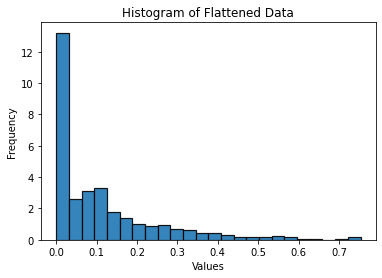

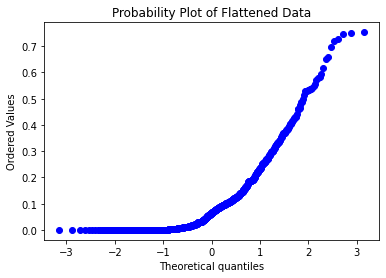

arr_clr_transformed Mean: 6.791328418256632e-17 
arr_clr_transformed Std: 2.3763887021860994


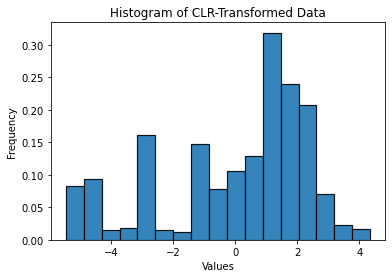

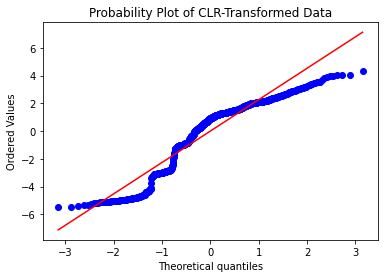

arr_standardized Mean: 3.4168871104353683e-16 
arr_standardized Std: 1.0


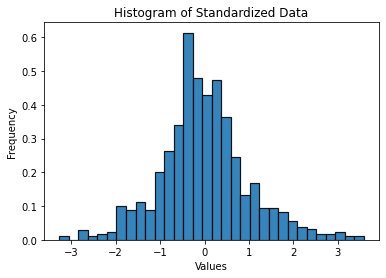

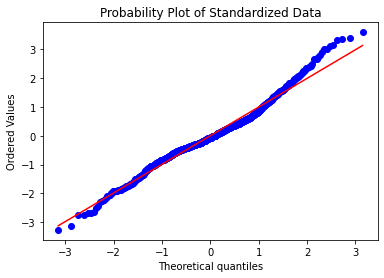

In [4]:
# Bring in the dataset
df = read_csv_file(filepath)

# Prepare the data for multivariate analysis
df2 = remove_nondata(df)
arr_closure = data_exploration(df2)
arr_clr_transformed = clr_transform(arr_closure)
arr_standardized = standardize_data(arr_clr_transformed)

arr_X = arr_standardized

# Principal Component Analysis

Total variance in the dataset is: 9.097826086956522
The 95% variance is:  8.642934782608695 

Variance explained with 2 components: 6.451892813732371
Variance explained with 3 components: 7.470695171326113
Variance explained with 4 components: 8.25977853205623
Variance explained with 5 components: 8.716710159271827
Variance explained with 6 components: 8.928606517876286 

   PCA Comp  Explained Variance
0         0        4.724129e+00
1         1        1.727764e+00
2         2        1.018802e+00
3         3        7.890834e-01
4         4        4.569316e-01
5         5        2.118964e-01
6         6        1.102580e-01
7         7        5.896158e-02
8         8        6.221472e-30 

Principal components and their explained variance (%):
PC1: 51.93
PC2: 18.99
PC3: 11.2
PC4: 8.67
PC5: 5.02


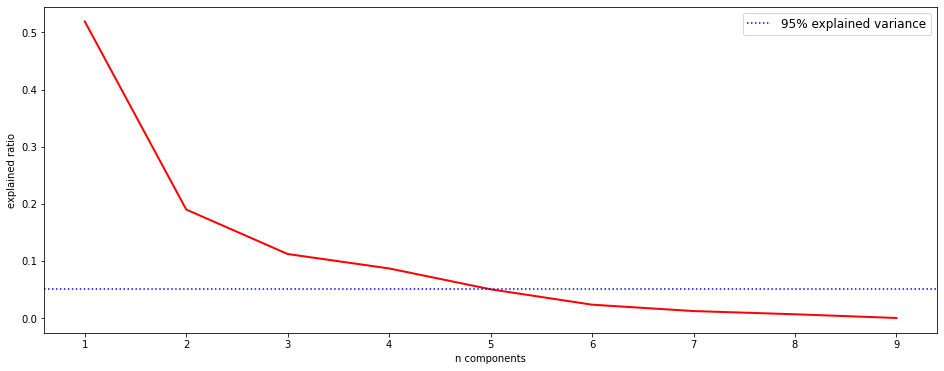

In [5]:
n_components = arr_clr_transformed.shape[1]

# Running PCA on all components
pca=PCA(n_components=n_components)
arr_X_r=pca.fit(arr_X).transform(arr_X)
a = pca_initial()

PC_explained_list = calculate_explained_variance_percent()

create_PC_scree_plot()

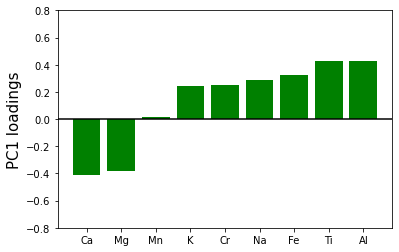

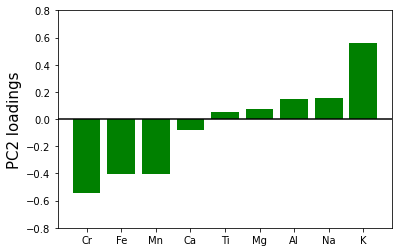

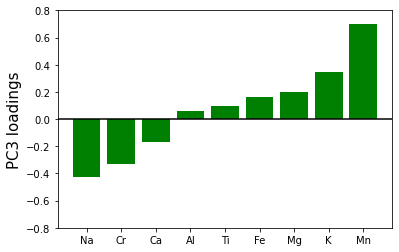

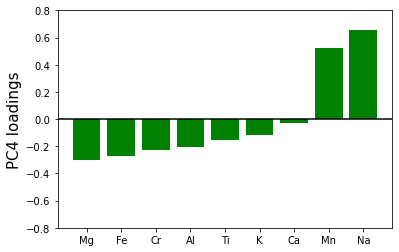

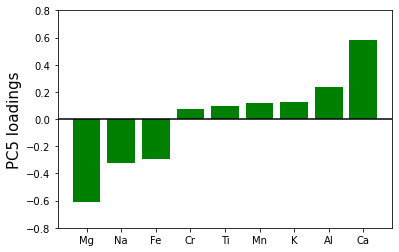

In [6]:
# Running PCA again, this time with the specified amount of components

# USER INPUT
n_components = 5

pca=PCA(n_components=n_components)
arr_X_r=pca.fit(arr_X).transform(arr_X)

# Generate PC loading plots
pc_columns = create_PC_columns()
create_PC_loading_plots()

# K-means Clustering

The inertia for 2 clusters is 522.278159068053
The inertia for 3 clusters is 415.24609081449364
The inertia for 4 clusters is 349.93053315457234
The inertia for 5 clusters is 303.8113516055358
The inertia for 6 clusters is 277.9803701762639
The inertia for 7 clusters is 246.24891697812978
The inertia for 8 clusters is 223.94222256487905
The inertia for 9 clusters is 202.24192270119278
The inertia for 10 clusters is 177.0401285459034
The inertia for 11 clusters is 172.93435771649365
The inertia for 12 clusters is 156.73535533447807
The inertia for 13 clusters is 146.87579488104586
The inertia for 14 clusters is 136.1886306199485
The inertia for 15 clusters is 127.88170400749004
The inertia for 16 clusters is 119.3989224948716
The inertia for 17 clusters is 118.71086177543546
The inertia for 18 clusters is 108.80740770472772
The inertia for 19 clusters is 103.24432360480306


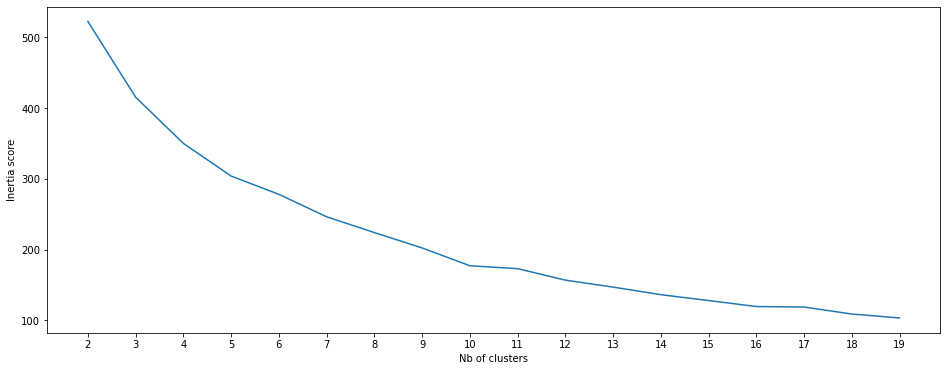

In [7]:
# Deciding the number of clusters to use

# Making a scree plot of inertia scores; the elbow method to determine the number of clusters. The 'elbow' method
#   is used to find the point of diminishing return. The elbow point (\_-shaped) on the plot represents a much smaller 
#   difference in intertia scores, and therefore may be interpreted as a good number of clusters to use.

create_Kmeans_scree_plot()

In [8]:
# Another method to determine the number of clusters (the Calinski-Harabasz score). In this method, the number of
#   clusters with the highest CH score is recommended.

Calinski_Harabasz_scores()

The Calinski Harabasz score for : 2 clusters is: 48.759367761785974
The Calinski Harabasz score for : 3 clusters is: 41.905526283465775
The Calinski Harabasz score for : 4 clusters is: 38.30849395941833
The Calinski Harabasz score for : 5 clusters is: 36.089656454607564
The Calinski Harabasz score for : 6 clusters is: 33.98052764513958
The Calinski Harabasz score for : 7 clusters is: 32.76199609430653
The Calinski Harabasz score for : 8 clusters is: 31.347172840635157
The Calinski Harabasz score for : 9 clusters is: 30.7190603158736
The Calinski Harabasz score for : 10 clusters is: 30.94773516699511
The Calinski Harabasz score for : 11 clusters is: 30.769430978275917
The Calinski Harabasz score for : 12 clusters is: 30.256853560423885
The Calinski Harabasz score for : 13 clusters is: 28.84980893149548
The Calinski Harabasz score for : 14 clusters is: 29.444527353240264
The Calinski Harabasz score for : 15 clusters is: 28.414630021148845
The Calinski Harabasz score for : 16 clusters is:

Number of data points in each cluster:


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,33,14,10,36


Explained variance (first five components): [0.51925911 0.18990951 0.11198305 0.08673318 0.05022426]


<Figure size 432x288 with 0 Axes>

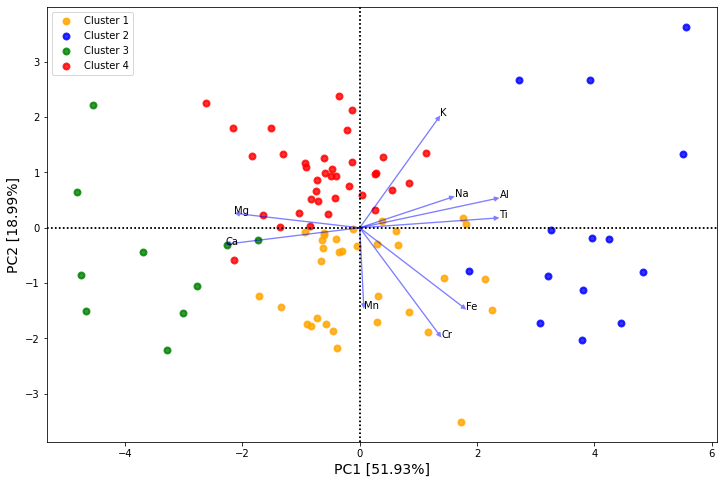

<Figure size 432x288 with 0 Axes>

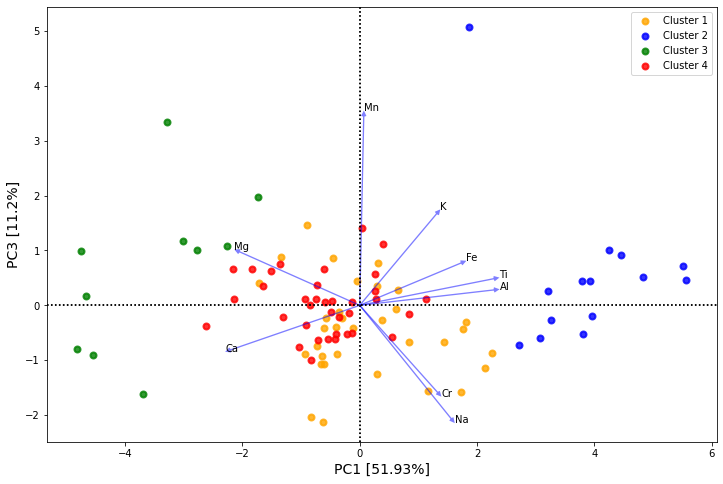

In [9]:
# Create a k-means model with the specified amount of clusters

# USER INPUT
number_of_clusters = 4

Kmeans_clustering()